本例子是 v1.0 的基金净值预测引擎，现在已经升级的 v3.0，不需要在参考该 notebook 的代码，请直接使用 ``xa.QDIIPredict`` 类即可，
各种情况都已做了妥善的封装和考虑

In [2]:
import xalpha as xa
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# 南方原油持仓及基准
# 38335 WisdomTree WTI Crude Oil
# 44793 United States 12 Month Oil Fund LP
# 995771 UBS ETF CHCMCI Oil SF USD A-dis https://cn.investing.com/etfs/ubs-cmci-oil-sf-usd
# 44794 United States Oil Fund LP
# 44792 Invesco DB Oil Fund
# 38324 WisdomTree Brent Crude Oil
# 44634 United States Brent Oil Fund LP
# 37450 WisdomTree Brent Crude Oil 1mth
# 1014132 iPath S&P GSCI Crude Oil Total Return Index ETN

# 8833 brent oil
# 8849 wti oil

# 2019 第四季度季报披露
# reference: http://pdf.dfcfw.com/pdf/H2_AN202001191374337197_1.pdf
holdings_501018_19s3 = {
    "37450": 15.31,
    "44792": 13.64,
    "44794": 13.46,
    "44634": 12.48,
    "38335": 11.73,
    "38324": 9.45,
    "995771": 6.53,
    "44793": 6.02,
    "1014132": 5.42,
}
# 2019 第三季度季报披露
# reference: http://pdf.dfcfw.com/pdf/H2_AN201910241369695857_1.pdf
holdings_501018_19s4 = {
    "38335": 7.34,
    "44793": 8.14,
    "995771": 8.68,
    "44794": 9.63,
    "44792": 11.6,
    "38324": 15.04,
    "44634": 15.42,
    "37450": 17.51,
    "1014132": 0.06,
}
holdings_501018_bc_cash = {"8849": 52.8, "8833": 35.2}
# holdings_bc = {"8849": 60, "8833": 40}

In [4]:
## 国泰商品相关基金持仓
# 14218 PROSHARES ULTRA BLOOMBERG CRUDE OIL
# 37471 Invesco DB US Dollar Index Bullish Fund (UUP)
## 44792 Invesco DB Oil Fund (DBO)
# 44798 VELOCITYSHARES 3X LONG CRUDE OIL ETN
# 44718 INVESCO DB PRECIOUS METALS FUND
# 9236 ISHARES SILVER TRUST (SLV)

holdings_160216_19s4 = {
    "44794": 16.9,
    "14218": 14.03,
    "44634": 11.77,
    "37471": 10.98,
    "44792": 9.1,
    "44798": 7.82,
    "1014132": 7.76,
    "44793": 2.25,
    "44718": 0.01,
    "9236": 0,
}
# reference: http://pdf.dfcfw.com/pdf/H2_AN202001161374256079_1.pdf

In [5]:
# 华宝油气
#  38284 SPDR® S&P Oil & Gas Exploration & Production ETF (XOP)
#  1010825 S&P Oil & Gas Exploration & Production Select Industry TR (SPSIOPTR)
# 华宝油气直接持仓 SPSIOPTR 成分股，而非买入 XOP，直接用油气指数模拟持仓
holdings_162411_19s4 = {"1010825": 90}
# reference: http://pdf.dfcfw.com/pdf/H2_AN202001201374387272_1.pdf

In [6]:
def cache_data(data, *args, start="20180101"):
    for arg in args:
        for k in arg:
            if k not in data:
                data[k] = xa.get_daily(k, start=start)


def daily_increment(code, date, lastday=None, _default=None):
    if not _default:
        tds = xa.get_daily(code=code, end=date, prev=15)
        tds = tds[tds["date"] <= date]
        if not lastday:
            ratio = tds.iloc[-1]["close"] / tds.iloc[-2]["close"]
        else:
            tds2 = tds[tds["date"] <= lastday]
            ratio = tds.iloc[-1]["close"] / tds2.iloc[-1]["close"]
        return ratio
    # _default table dict is existing
    tds = _default[code][_default[code]["date"] <= date]
    if not lastday:
        ratio = tds.iloc[-1]["close"] / tds.iloc[-2]["close"]
    else:
        tds2 = tds[tds["date"] <= lastday]
        ratio = tds.iloc[-1]["close"] / tds2.iloc[-1]["close"]
    return ratio


def evaluate_fluctuation(holding_dict, date, lastday=None, _default=None, _usd=""):
    price = 0
    tot = 0
    for k, v in holding_dict.items():
        tot += v
    remain = 100 - tot
    for fundid, percent in holding_dict.items():
        ratio = daily_increment(fundid, date, lastday, _default=_default)
        #         print(fundid, ratio)
        price += ratio * percent / 100
    price += remain / 100  # currency part
    if _usd:  # 美元资产需换算汇率, 中间价数据似乎精确度好于市场数据 2111
        price = price * daily_increment(_usd, date, lastday, _default=_default)
    return (price - 1) * 100


def estimate_table(start, end, *cols, _default=None):
    """

    :param cols: Tuple[str, str, Dict]. (colname, _usd, holding_dict).
    """
    compare_data = {
        "date": [],
    }
    for col in cols:
        compare_data[col[0]] = []
    dl = pd.Series(pd.date_range(start=start, end=end))
    dl = dl[dl.isin(xa.cons.opendate)]
    for i, d in enumerate(dl):
        if i == 0:
            continue

        dstr = d.strftime("%Y%m%d")
        lstdstr = dl.iloc[i - 1].strftime("%Y%m%d")
        compare_data["date"].append(d)
        for col in cols:
            compare_data[col[0]].append(
                evaluate_fluctuation(
                    col[2], dstr, lstdstr, _default=_default, _usd=col[1]
                )
            )
    cpdf = pd.DataFrame(compare_data)
    col0 = cols[0]
    for col in cols[1:]:
        cpdf["diff_" + col0[0] + "_" + col[0]] = cpdf[col0[0]] - cpdf[col[0]]
    return cpdf

In [9]:
cache_table = {}
cache_data(
    cache_table,
    holdings_160216_19s4,
    holdings_162411_19s4,
    holdings_501018_19s3,
    holdings_501018_19s4,
    holdings_501018_bc_cash,
    ["F501018", "USD/CNY", "2111", "F160216", "F162411"],
)

## 南方原油净值预估

In [91]:
nfyydf = estimate_table(
    "20190101",
    "20200305",
    ("real", "", {"F501018": 100}),
    ("fund_est", "USD/CNY", holdings_501018_19s4),
    ("fund_est_2111", "2111", holdings_501018_19s4),
    ("bc_est", "USD/CNY", holdings_501018_bc_cash),
    ("bc_est_2111", "2111", holdings_501018_bc_cash),
    _default=cache_table,
)

In [27]:
nfyydf.iloc[-20:]

,date,real,fund_est,fund_est_2111,bc_est,bc_est_2111,diff_real_fund_est,diff_real_fund_est_2111,diff_real_bc_est,diff_real_bc_est_2111
263,2020-02-07,-0.647948,-0.785591,-0.037261,-1.254779,-0.509988,0.137642,-0.610687,0.606830,-0.137960
264,2020-02-10,-1.096838,-1.426025,-1.800490,-1.428398,-1.802854,0.329187,0.703652,0.331560,0.706016
265,2020-02-11,0.429613,0.624201,0.310294,0.932186,0.617319,-0.194587,0.119319,-0.502573,-0.187706
266,2020-02-12,1.571827,2.244064,2.593395,2.198130,2.547303,-0.672238,-1.021568,-0.626303,-0.975477
267,2020-02-13,0.333007,0.504982,0.481938,0.701662,0.678573,-0.171975,-0.148931,-0.368655,-0.345566
268,2020-02-14,0.829754,1.198974,1.258412,1.343349,1.402872,-0.369220,-0.428658,-0.513595,-0.573118
269,2020-02-17,0.116178,-0.021618,-0.033048,0.298117,0.286651,0.137796,0.149225,-0.181939,-0.170473
270,2020-02-18,-0.232086,-0.002015,0.181235,-0.058525,0.124622,-0.230071,-0.413321,-0.173561,-0.356708
271,2020-02-19,2.268101,2.533318,2.275533,2.364867,2.107506,-0.265216,-0.007432,-0.096765,0.160596
272,2020-02-20,0.710833,0.478790,0.813269,0.618737,0.953681,0.232043,-0.102436,0.092097,-0.242848


In [35]:
(
    np.mean(np.abs(nfyydf["diff_real_fund_est"][-100:])),
    np.mean(np.abs(nfyydf["diff_real_fund_est_2111"][-100:])),
    np.mean(np.abs(nfyydf["diff_real_bc_est"][-100:])),
    np.mean(np.abs(nfyydf["diff_real_bc_est_2111"][-100:])),
)

(0.13494830952722817,
 0.2729164993400751,
 0.422895067226587,
 0.4503039730692361)

可以看出，人民币中间价做汇率换算，比人民币市场价格要准很多，利用基金持仓的涨跌直接估算，也要比用基准准很多。
南方原油大家一直抱怨不好估值，但我想 0.13 个百分点的平均误差水平应该是全网最准了。因为我想不到比直接从持仓开始算更准的方式了。
如果有方式用最近100交易日的数据可以打败这一偏移水平，欢迎告诉我。

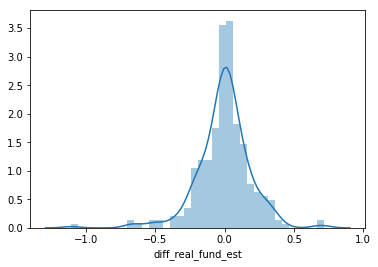

In [38]:
% matplotlib inline
sns.distplot(nfyydf["diff_real_fund_est"])

In [40]:
len([i for i in nfyydf["diff_real_fund_est"][-100:] if abs(i) > 0.5]) / 100

0.05

可以看出有大约5%的概率，预测净值和真实净值的偏差超过0.5个百分点，总体上是一个可以接受的净值预测
可以和其他qdii基金比一下预测精度

In [92]:
# 反向预测的比例
p = 0
n = 0
for i, row in nfyydf.iterrows():
    r = row["fund_est"] * row["real"]
    if r >= 0:
        p += 1
    else:
        n += 1
print(p, n, n / (n + p))
# 竟然有4%+的机会预测完全反号。。。。

271 12 0.04240282685512368


## 国泰商品净值预估

In [42]:
gtspdf = estimate_table(
    "20190101",
    "20200305",
    ("real", "", {"F160216": 100}),
    ("fund_est", "USD/CNY", holdings_160216_19s4),
    ("fund_est_2111", "2111", holdings_160216_19s4),
    _default=cache_table,
)

In [43]:
gtspdf.iloc[-20:]

,date,real,fund_est,fund_est_2111,diff_real_fund_est,diff_real_fund_est_2111
263,2020-02-07,-1.173709,-1.508188,-0.765309,0.334479,-0.408400
264,2020-02-10,-1.425178,-1.450684,-1.825055,0.025506,0.399877
265,2020-02-11,0.963855,0.941957,0.627059,0.021899,0.336796
266,2020-02-12,2.147971,2.610018,2.960598,-0.462046,-0.812627
267,2020-02-13,0.233645,0.378472,0.355457,-0.144827,-0.121812
268,2020-02-14,1.165501,1.056623,1.115977,0.108878,0.049524
269,2020-02-17,-0.230415,-0.068726,-0.080150,-0.161689,-0.150265
270,2020-02-18,0.230947,0.149082,0.332609,0.081865,-0.101663
271,2020-02-19,2.304147,2.297944,2.040751,0.006204,0.263396
272,2020-02-20,0.675676,0.739045,1.074390,-0.063369,-0.398714


In [44]:
(
    np.mean(np.abs(gtspdf["diff_real_fund_est"][-100:])),
    np.mean(np.abs(gtspdf["diff_real_fund_est_2111"][-100:])),
)

(0.10589187603833962, 0.22399439609501928)

In [65]:
# 看看有没有肉眼可见的系统偏差
(
    np.mean(gtspdf["diff_real_fund_est"][-150:-100]),
    np.mean(gtspdf["diff_real_fund_est"][-100:-50]),
    np.mean(gtspdf["diff_real_fund_est"][-50:]),
)
# 最近的最准，也可以理解，毕竟是按照4季度底持仓模拟的

(-0.02266683846031749, -0.023893072096493828, 0.007916101144943788)

预测精度要比南方原油好，用人民币中间价，平均误差只有0.1个百分点。

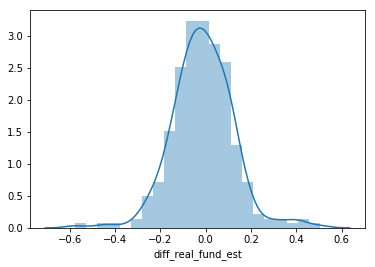

In [45]:
sns.distplot(gtspdf["diff_real_fund_est"])  # 看误差分布展宽也明显比南方原油窄

In [55]:
len([i for i in gtspdf["diff_real_fund_est"][-100:] if abs(i) > 0.31]) / 100

0.05

极端值情况，5%分位的误差偏移仅有0.31个百分点，也比南方原油强不少，因此国泰商品预测性更强，更适合套利，或者说套利溢价的阈值更低，因为溢价预测的误差窗口小一些。

我们再看一下，预测误差的正负和实际上涨与下降之间的关系，这之前先看一下完全反号的预测

In [57]:
p = 0
n = 0
for i, row in gtspdf.iterrows():
    r = row["fund_est"] * row["real"]
    if r >= 0:
        p += 1
    else:
        n += 1
print(p, n, n / (n + p))
# 并没有反向预测这种严重错误，这是一个好消息！

283 0 0.0


In [58]:
uu, ud, dd, du = 0, 0, 0, 0
# uu 实际上涨，real-est>0 (预测涨的少)
# ud 预测涨的多
# du 预测跌的多
# dd 预测跌的少
for i, row in gtspdf.iterrows():
    if row["real"] >= 0 and row["diff_real_fund_est"] > 0:
        uu += 1
    elif row["real"] >= 0 and row["diff_real_fund_est"] <= 0:
        ud += 1
    elif row["real"] < 0 and row["diff_real_fund_est"] > 0:
        du += 1
    else:
        dd += 1
print(uu, ud, du, dd)

65 99 63 56


还是比较平均的，预测涨的比实际多的情况稍多。也就是说预计涨的时候，可能预计的偏大。预计跌的时候，还是没有什么系统性误差的。

说人话就是基金涨的时候跟不上持仓，跌的时候跟挺紧。。。

## 华宝油气净值预估情况

In [59]:
hbyqdf = estimate_table(
    "20190101",
    "20200305",
    ("real", "", {"F162411": 100}),
    ("fund_est", "USD/CNY", holdings_162411_19s4),
    ("fund_est_2111", "2111", holdings_162411_19s4),
    _default=cache_table,
)

In [62]:
hbyqdf.iloc[-20:]

,date,real,fund_est,fund_est_2111,diff_real_fund_est,diff_real_fund_est_2111
263,2020-02-07,-1.873199,-1.913981,-1.174162,0.040782,-0.699037
264,2020-02-10,-2.055800,-2.121451,-2.493273,0.065650,0.437473
265,2020-02-11,0.539730,0.578453,0.264689,-0.038723,0.275041
266,2020-02-12,0.745601,0.792262,1.136632,-0.046661,-0.391031
267,2020-02-13,-0.266430,-0.265953,-0.288820,-0.000477,0.022391
268,2020-02-14,-0.831107,-0.931193,-0.873006,0.100086,0.041899
269,2020-02-17,-0.089793,-0.068726,-0.080150,-0.021068,-0.009643
270,2020-02-18,-0.629119,-0.674867,-0.492850,0.045748,-0.136270
271,2020-02-19,2.653000,2.920169,2.661412,-0.267169,-0.008412
272,2020-02-20,0.205580,0.234215,0.567880,-0.028635,-0.362300


这个净值预估就有点意思了，因为雪球上油气姐也有每日官方的净值预报，让我们比一下谁的更准
要知道实在不行我们还有个持仓比例的超参可以调！

下面是雪球的预估数据
3.5 -4.06
3.4 0.33
3.3 -3.21
3.2 -0.77
2.28 3.39

就拿最新五天的数据为例，四天都是我们上面的预计更准，因此可以说也是全网最准了，毕竟比官方的预估要接近真实值

In [68]:
(
    np.mean(np.abs(hbyqdf["diff_real_fund_est"][-200:])),
    np.mean(np.abs(hbyqdf["diff_real_fund_est_2111"][-200:])),
)

(0.11470246307431636, 0.25056930156434193)

油气的预测平均偏差是0.11个百分点强，比国泰商品的预测精度还低，同样是人民币中间价比市价准很多。
这样看国泰商品竟然是比华宝油气这种跟踪单一指数的产品净值预测更容易，估计这颠覆了很多人的认识

In [69]:
(
    np.mean(hbyqdf["diff_real_fund_est"][-150:-100]),
    np.mean(hbyqdf["diff_real_fund_est"][-100:-50]),
    np.mean(hbyqdf["diff_real_fund_est"][-50:]),
)

(-0.03564024234015609, -0.009798129247228005, 0.02813788155226706)

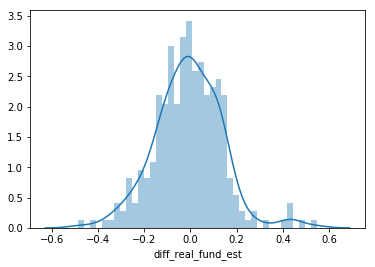

In [73]:
sns.distplot(hbyqdf["diff_real_fund_est"], bins=40)  # 误差分布涨的有点丑, 好像确实也没有国泰商品的正态

In [77]:
len([i for i in hbyqdf["diff_real_fund_est"][-100:] if abs(i) > 0.40]) / 100

0.05

百分之五极端分位是预测偏离0.4个百分点

In [80]:
p = 0
n = 0
for i, row in hbyqdf.iterrows():
    r = row["fund_est"] * row["real"]
    if r >= 0:
        p += 1
    else:
        n += 1
print(p, n, n / (n + p))
# 无反相预测

283 0 0.0


In [81]:
uu, ud, dd, du = 0, 0, 0, 0
# uu 实际上涨，real-est>0 (预测涨的少)
# ud 预测涨的多
# du 预测跌的多
# dd 预测跌的少
for i, row in hbyqdf.iterrows():
    if row["real"] >= 0 and row["diff_real_fund_est"] > 0:
        uu += 1
    elif row["real"] >= 0 and row["diff_real_fund_est"] <= 0:
        ud += 1
    elif row["real"] < 0 and row["diff_real_fund_est"] > 0:
        du += 1
    else:
        dd += 1
print(uu, ud, du, dd)

78 67 58 80


对于华宝油气，预估涨的时候往往预估得不如真实涨的多；预估跌的时候，往往预估比实际跌的少，这似乎说明华宝油气预估的仓位不足，导致预估倾向比较小，让我们调一下这个超参

In [88]:
hbyqdf91 = estimate_table(
    "20190101",
    "20200305",
    ("real", "", {"F162411": 100}),
    ("fund_est", "USD/CNY", {"1010825": 91}),
    ("fund_est_2111", "2111", {"1010825": 91}),
    _default=cache_table,
)

In [89]:
uu, ud, dd, du = 0, 0, 0, 0
# uu 实际上涨，real-est>0 (预测涨的少)
# ud 预测涨的多
# du 预测跌的多
# dd 预测跌的少
for i, row in hbyqdf91.iterrows():
    if row["real"] >= 0 and row["diff_real_fund_est"] > 0:
        uu += 1
    elif row["real"] >= 0 and row["diff_real_fund_est"] <= 0:
        ud += 1
    elif row["real"] < 0 and row["diff_real_fund_est"] > 0:
        du += 1
    else:
        dd += 1
print(uu, ud, du, dd)

72 73 62 76


In [90]:
np.mean(np.abs(hbyqdf91["diff_real_fund_est"][-200:]))  # 偏差大了点，但是预测与实际涨跌偏差的正负比较对称了
# 所以仓位90 91 自己看着办吧，差不太多

0.11827697989010805

## DAX30

In [8]:
cache_data(cache_table, ["EUR/CNY", "/indices/germany-30", "F513030"])

In [33]:
daxdf = estimate_table(
    "20190101",
    "20200305",
    ("real", "", {"F513030": 100}),
    ("fund_est", "EUR/CNY", {"/indices/germany-30": 97}),
    _default=cache_table,
)

# 这里的仓位97是调超参得到的最好结果

In [34]:
np.mean(np.abs(daxdf["diff_real_fund_est"][-200:]))
# 平均 0.03 偏移，德国30跟踪还是很可以的

0.03418095656058967

In [28]:
daxdf.iloc[-20:]

,date,real,fund_est,diff_real_fund_est
263,2020-02-07,-0.884956,-0.878367,-0.006589
264,2020-02-10,-0.267857,-0.259268,-0.008590
265,2020-02-11,0.626679,0.580633,0.046046
266,2020-02-12,0.711744,0.693314,0.018430
267,2020-02-13,-0.353357,-0.357733,0.004376
268,2020-02-14,-0.265957,-0.228721,-0.037236
269,2020-02-17,0.177778,0.216454,-0.038676
270,2020-02-18,-0.709849,-0.725345,0.015496
271,2020-02-19,0.714924,0.663141,0.051783
272,2020-02-20,-0.798580,-0.712748,-0.085832


In [19]:
(
    np.mean(daxdf["diff_real_fund_est"][-200:-100]),
    np.mean(daxdf["diff_real_fund_est"][-200:]),
)

(-0.010051134143197249, -0.0079593039572593)

In [35]:
uu, ud, dd, du = 0, 0, 0, 0
# uu 实际上涨，real-est>0 (预测涨的少)
# ud 预测涨的多
# du 预测跌的多
# dd 预测跌的少
for i, row in daxdf.iterrows():
    if row["real"] >= 0 and row["diff_real_fund_est"] > 0:
        uu += 1
    elif row["real"] >= 0 and row["diff_real_fund_est"] <= 0:
        ud += 1
    elif row["real"] < 0 and row["diff_real_fund_est"] > 0:
        du += 1
    else:
        dd += 1
print(uu, ud, du, dd)

76 80 48 79


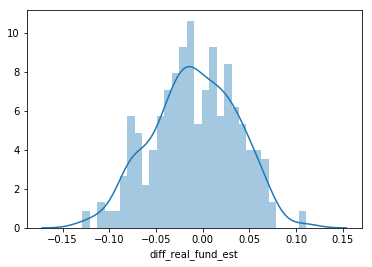

In [37]:
%matplotlib inline
sns.distplot(daxdf["diff_real_fund_est"], bins=30)